In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_met
import glob
import metpy
from metpy import calc
from metpy.units import units
from scipy import stats
import metpy
from metpy import calc
from metpy.units import units
import pickle as pkl

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
regions = {
'equatorial' : [(-5,0)],
'transition' : [(-8,-5)],
'central' : [(-12,-8)],
'southern' : [(-17,-15)]}
h = 2000

In [4]:
topo_full = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/ERA5_static_hourly_0.25deg_peru.nc')
topo_full = uda.flip_lat(topo_full)

In [5]:
height = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/topo_ERA5_peru.nc')['h']


In [6]:
def read(region):
    
    alls = regions[region]
    hei = height.sel(latitude=slice(alls[0][0], alls[0][1])).mean('latitude').squeeze()
    topo = topo_full['z'].sel(latitude=slice(alls[0][0], alls[0][1])).mean('latitude').squeeze()
    inpath = '/media/ck/Elements/SouthAmerica/ERA5/hourly/'+region+'_cross_15UTC_1985-2018_peru_v2.nc'
    
    ds = xr.open_dataset(inpath)
    ds_filtered = ds.where(ds['z']>topo)
    
    return ds_filtered

In [7]:
def calc_from_era(ds):
    pdub = np.array([list(ds.level.values),]*len(ds.longitude)).T
    p = units.Quantity(pdub, 'hPa')
    #print(p)
    t = units.Quantity(ds['t'].values, 'K')
    q = units.Quantity(ds['q'].values, 'kg/kg')
    dew = calc.dewpoint_from_specific_humidity(q, t, p)
    #ipdb.set_trace()
    theta_es = np.array(calc.saturation_equivalent_potential_temperature(p,t))#-273.15
    theta_e = np.array(calc.equivalent_potential_temperature(p,t,dew))#-273.15
    theta = np.array(calc.potential_temperature(p,t))
    theta_e_mine = u_met.theta_e(ds.level.values, ds['t'].values-273.15, ds['q'].values)+273.15
    
    tes = ds['q'].copy(deep=True)
    te = ds['q'].copy(deep=True)
    tem = ds['q'].copy(deep=True)
    th = ds['q'].copy(deep=True)
    
    tes.values = theta_es
    te.values = theta_e
    tem.values = theta_e_mine
    th.values = theta
    ds['theta_es'] = tes
    ds['theta_e'] = te
    ds['theta_em'] = tem
    ds['theta'] = th

    return ds#theta_es, theta_e, theta_e_mine

In [8]:
def apply_drywet(ds, region, spell=3, minus='0days', plus='0days', area=0.2):
    dwspells = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+region+"_dw_spellDates_"+str(area)+"perc_v2.p", "rb"))
    
    
    dds = dwspells['dry'+str(spell)] -pd.Timedelta(minus) + pd.Timedelta(plus)
    wds = dwspells['wet'+str(spell)] -pd.Timedelta(minus) + pd.Timedelta(plus)
    
    print('dry', len(dds), 'wet', len(wds))
    xy, x_ind, y_ind  = np.intersect1d(dds, ds.time, return_indices=True)
    dds = dds[x_ind]
    
    xy, x_ind, y_ind  = np.intersect1d(wds, ds.time, return_indices=True)
    wds = wds[x_ind]
    print('dry2', len(dds), 'wet2', len(wds))

    mean_dry = ds.sel(time=dds).mean('time')
    mean_wet = ds.sel(time=wds).mean('time')
    all_dry = ds.sel(time=dds)
    all_wet = ds.sel(time=wds)
    
    ## clims
    doy_dryclim = ds.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(dds.dayofyear)).mean('dayofyear')
    doy_wetclim = ds.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(wds.dayofyear)).mean('dayofyear')
    
    doy_dryclim = ds.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(dds.dayofyear)).mean('dayofyear')
    doy_wetclim = ds.groupby('time.dayofyear').mean('time').sel(dayofyear=np.unique(wds.dayofyear)).mean('dayofyear')
    
    xyd, x_indd, y_indd = np.intersect1d(ds['time.dayofyear'].values,dds.dayofyear.values, return_indices=True)
    xyw, x_indw, y_indw = np.intersect1d(ds['time.dayofyear'].values,wds.dayofyear.values, return_indices=True)
    
    #ipdb.set_trace()
    wdays = []
    for dst in ds.time:
        if dst['time.dayofyear'].values in wds.dayofyear.values:
            wdays.append(dst.time.values)
    ddays = []
    for dst in ds.time:
        if dst['time.dayofyear'].values in dds.dayofyear.values:
            ddays.append(dst.time.values)
    #ipdb.set_trace()
    doy_dryclim_all = ds.sel(time=ddays)
    doy_wetclim_all = ds.sel(time=wdays)
    #
    mean_clim = ds.mean('time')
    
    
    for dat in [mean_dry, mean_wet, doy_dryclim, doy_wetclim, mean_clim]:
        dat = calc_from_era(dat)
    
    
    outdic = {'dry' : mean_dry,
              'wet' : mean_wet,
              'dry_ttest' : all_dry,
              'wet_ttest' : all_wet,
              'dry_doyclim' : doy_dryclim,
              'wet_doyclim' : doy_wetclim,
              'mean_clim' : mean_clim,
              'all_clim' : ds,
              'dry_doyclim_ttest' : doy_dryclim_all,
              'wet_doyclim_ttest' : doy_wetclim_all}
    
    return outdic

In [35]:
ar = 0.15
spelldays = 3

In [36]:
reg_tag = 'transition'
ds_filtered = read(reg_tag)

In [37]:
transition_dic = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='0days', plus='1days', area=0.2)
transition_dic_n1 = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='1days', plus='0days', area=0.2)

dry 366 wet 244
dry2 365 wet2 244
dry 366 wet 244
dry2 365 wet2 244


In [38]:
reg_tag = 'equatorial'
ds_filtered = read(reg_tag)

In [39]:
equatorial_dic = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='0days', plus='1days', area=ar)
equatorial_dic_n1 = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='1days', plus='0days', area=ar)

dry 622 wet 430
dry2 615 wet2 428
dry 622 wet 430
dry2 613 wet2 428


In [40]:
reg_tag = 'central'
ds_filtered = read(reg_tag)

In [41]:
central_dic = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='0days', plus='1days', area=ar)
central_dic_n1 = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='1days', plus='0days', area=ar)

dry 349 wet 426
dry2 342 wet2 424
dry 349 wet 426
dry2 342 wet2 423


In [42]:
reg_tag = 'southern'
ds_filtered = read(reg_tag)

In [43]:
southern_dic = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='0days', plus='1days', area=ar)
southern_dic_n1 = apply_drywet(ds_filtered, reg_tag, spell=spelldays, minus='1days', plus='0days', area=ar)

dry 143 wet 101
dry2 137 wet2 101
dry 143 wet 101
dry2 138 wet2 100


In [19]:
def readERA(var):
    
    print('Opening', glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-*_peru_*.nc')[0])
    u200orig = xr.open_dataset(glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+var+'_15UTC_1981-*_peru_*.nc')[0])
    u200orig = uda.flip_lat(u200orig)
    datetimes = pd.to_datetime(u200orig.time.values)
    newtimes = []
    for t in datetimes:
        newtimes.append(t.replace(hour=0))
    u200orig['time'] = ('time', newtimes)
    return u200orig

In [20]:
maps = readERA('v850')
maps = maps.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/v850_15UTC_1981-2019_peru_big.nc


In [21]:
mapsu = readERA('u850')
mapsu = mapsu.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/u850_15UTC_1981-2021_peru_big.nc


In [22]:
mapsq = readERA('q850')
mapsq = mapsq.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/q850_15UTC_1981-2019_peru_big.nc


In [23]:
mapsu2 = readERA('u250')
mapsu2 = mapsu2.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/u250_15UTC_1981-2018_peru_big.nc


In [24]:
mapsv2 = readERA('v250')
mapsv2 = mapsv2.sel(latitude=slice(-25,0), longitude=slice(-81,-55)).load()

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/v250_15UTC_1981-2018_peru_big.nc


In [25]:
topo = xr.open_dataarray(cnst.TOPO_1MIN).sel(lon=slice(-81,-55), lat=slice(-25,0))
height = maps.salem.lookup_transform(topo)

In [26]:
mcs = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/CHIRPS/SA_daily_onERA/CHIRPS_daily_onERA_*.nc')

In [27]:
#tir = mcs['tir'].sel(time=((mcs['time.year']>=1985)&(mcs['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-58)).load()
tir = mcs['precip'].sel(time=((mcs['time.year']>=1985)&(mcs['time.year']<=2018))).sel(latitude=slice(-25,0), longitude=slice(-81,-58)).load()

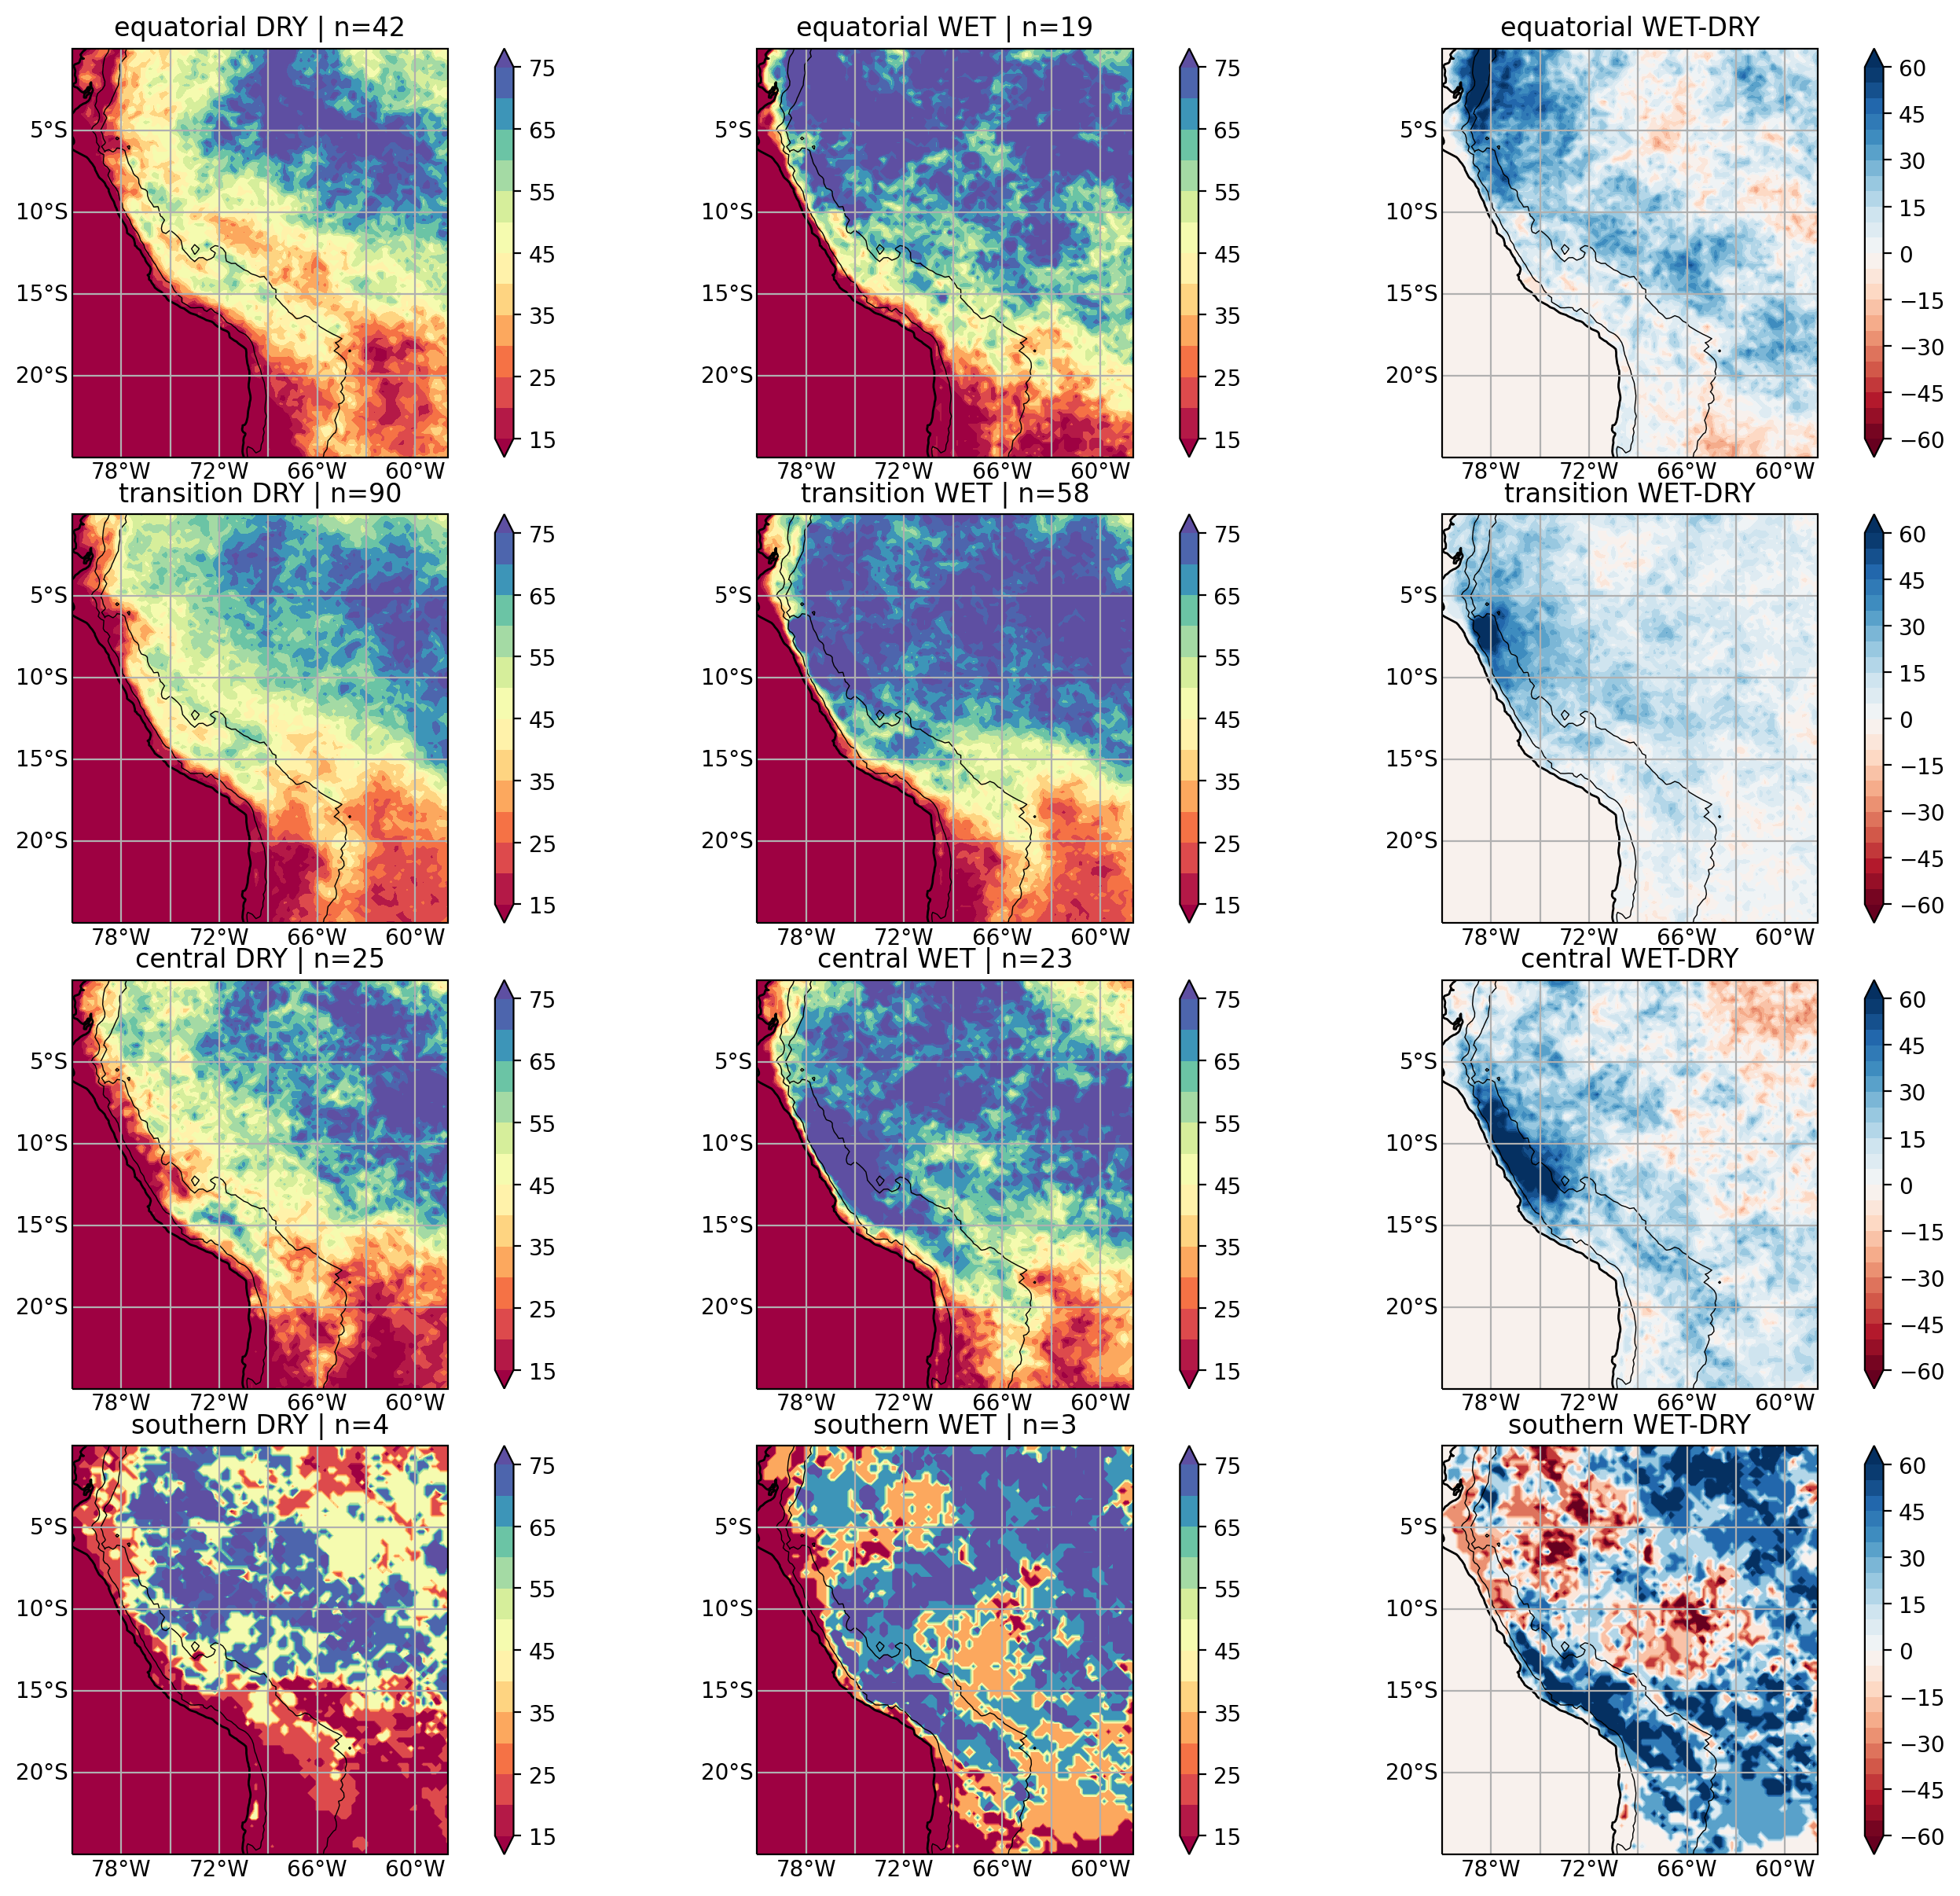

In [28]:
area = 0.15
f = plt.figure(figsize=(15,12), dpi=200)
plus = [1,2,3]
cnt = 0

for ids, reg in enumerate(['equatorial', 'transition', 'central', 'southern']):
    
    dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+reg+"_dw_spellDates_"+str(area)+"perc_western_v2.p", "rb"))
    
    dd = dic['dry3']#- pd.Timedelta('1days')
    wd = dic['wet3']#- pd.Timedelta('1days')
    drytir = np.intersect1d(tir.time.values, dd)
    wettir = np.intersect1d(tir.time.values, wd)
    
    tirdry = tir.where(tir>1).sel(time=drytir).count('time')/len(drytir)*100
    tirwet = tir.where(tir>1).sel(time=wettir).count('time')/len(wettir)*100

    ax = f.add_subplot(4,3,(ids+1)+cnt, projection=ccrs.PlateCarree())


    ax.coastlines()
            # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False


    plt.contourf(tirdry.longitude, tirdry.latitude, tirdry, levels=np.arange(15,76,5), cmap='Spectral', transform=ccrs.PlateCarree(), extend='both')
    plt.colorbar()
    plt.contour(height.longitude, height.latitude, height, levels=[-5,2000], colors='k', linewidths=0.5)
    ax.set_xlim(-81,-58)
    ax.set_ylim(-25,0)
    plt.title(reg+' DRY | n='+str(len(dd)))

    ax = f.add_subplot(4,3,ids+2+cnt, projection=ccrs.PlateCarree())
    ax.coastlines()
    plt.contourf(tirwet.longitude, tirwet.latitude, tirwet, levels=np.arange(15,76,5), cmap='Spectral', transform=ccrs.PlateCarree(), extend='both')
    plt.colorbar()
    plt.contour(height.longitude, height.latitude, height, levels=[-5,2000], colors='k', linewidths=0.5)
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    ax.set_xlim(-81,-58)
    ax.set_ylim(-25,0)
    plt.title(reg+' WET | n='+str(len(wd)))

    ax = f.add_subplot(4,3,ids+3+cnt, projection=ccrs.PlateCarree())
    ax.coastlines()
    plt.contourf(tirwet.longitude, tirwet.latitude, (tirwet-tirdry), levels=np.arange(-60,61,5), cmap='RdBu', transform=ccrs.PlateCarree(), extend='both')
    plt.colorbar()
    plt.contour(height.longitude, height.latitude, height, levels=[-5,2000], colors='k', linewidths=0.5)
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    ax.set_xlim(-81,-58)
    ax.set_ylim(-25,0)
    plt.title(reg+' WET-DRY')
    
    cnt +=2

    plt.tight_layout()
    #f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/correlations/drywet/gridsat_3days_day0_'+pregion+'.jpg')

/home/ck/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


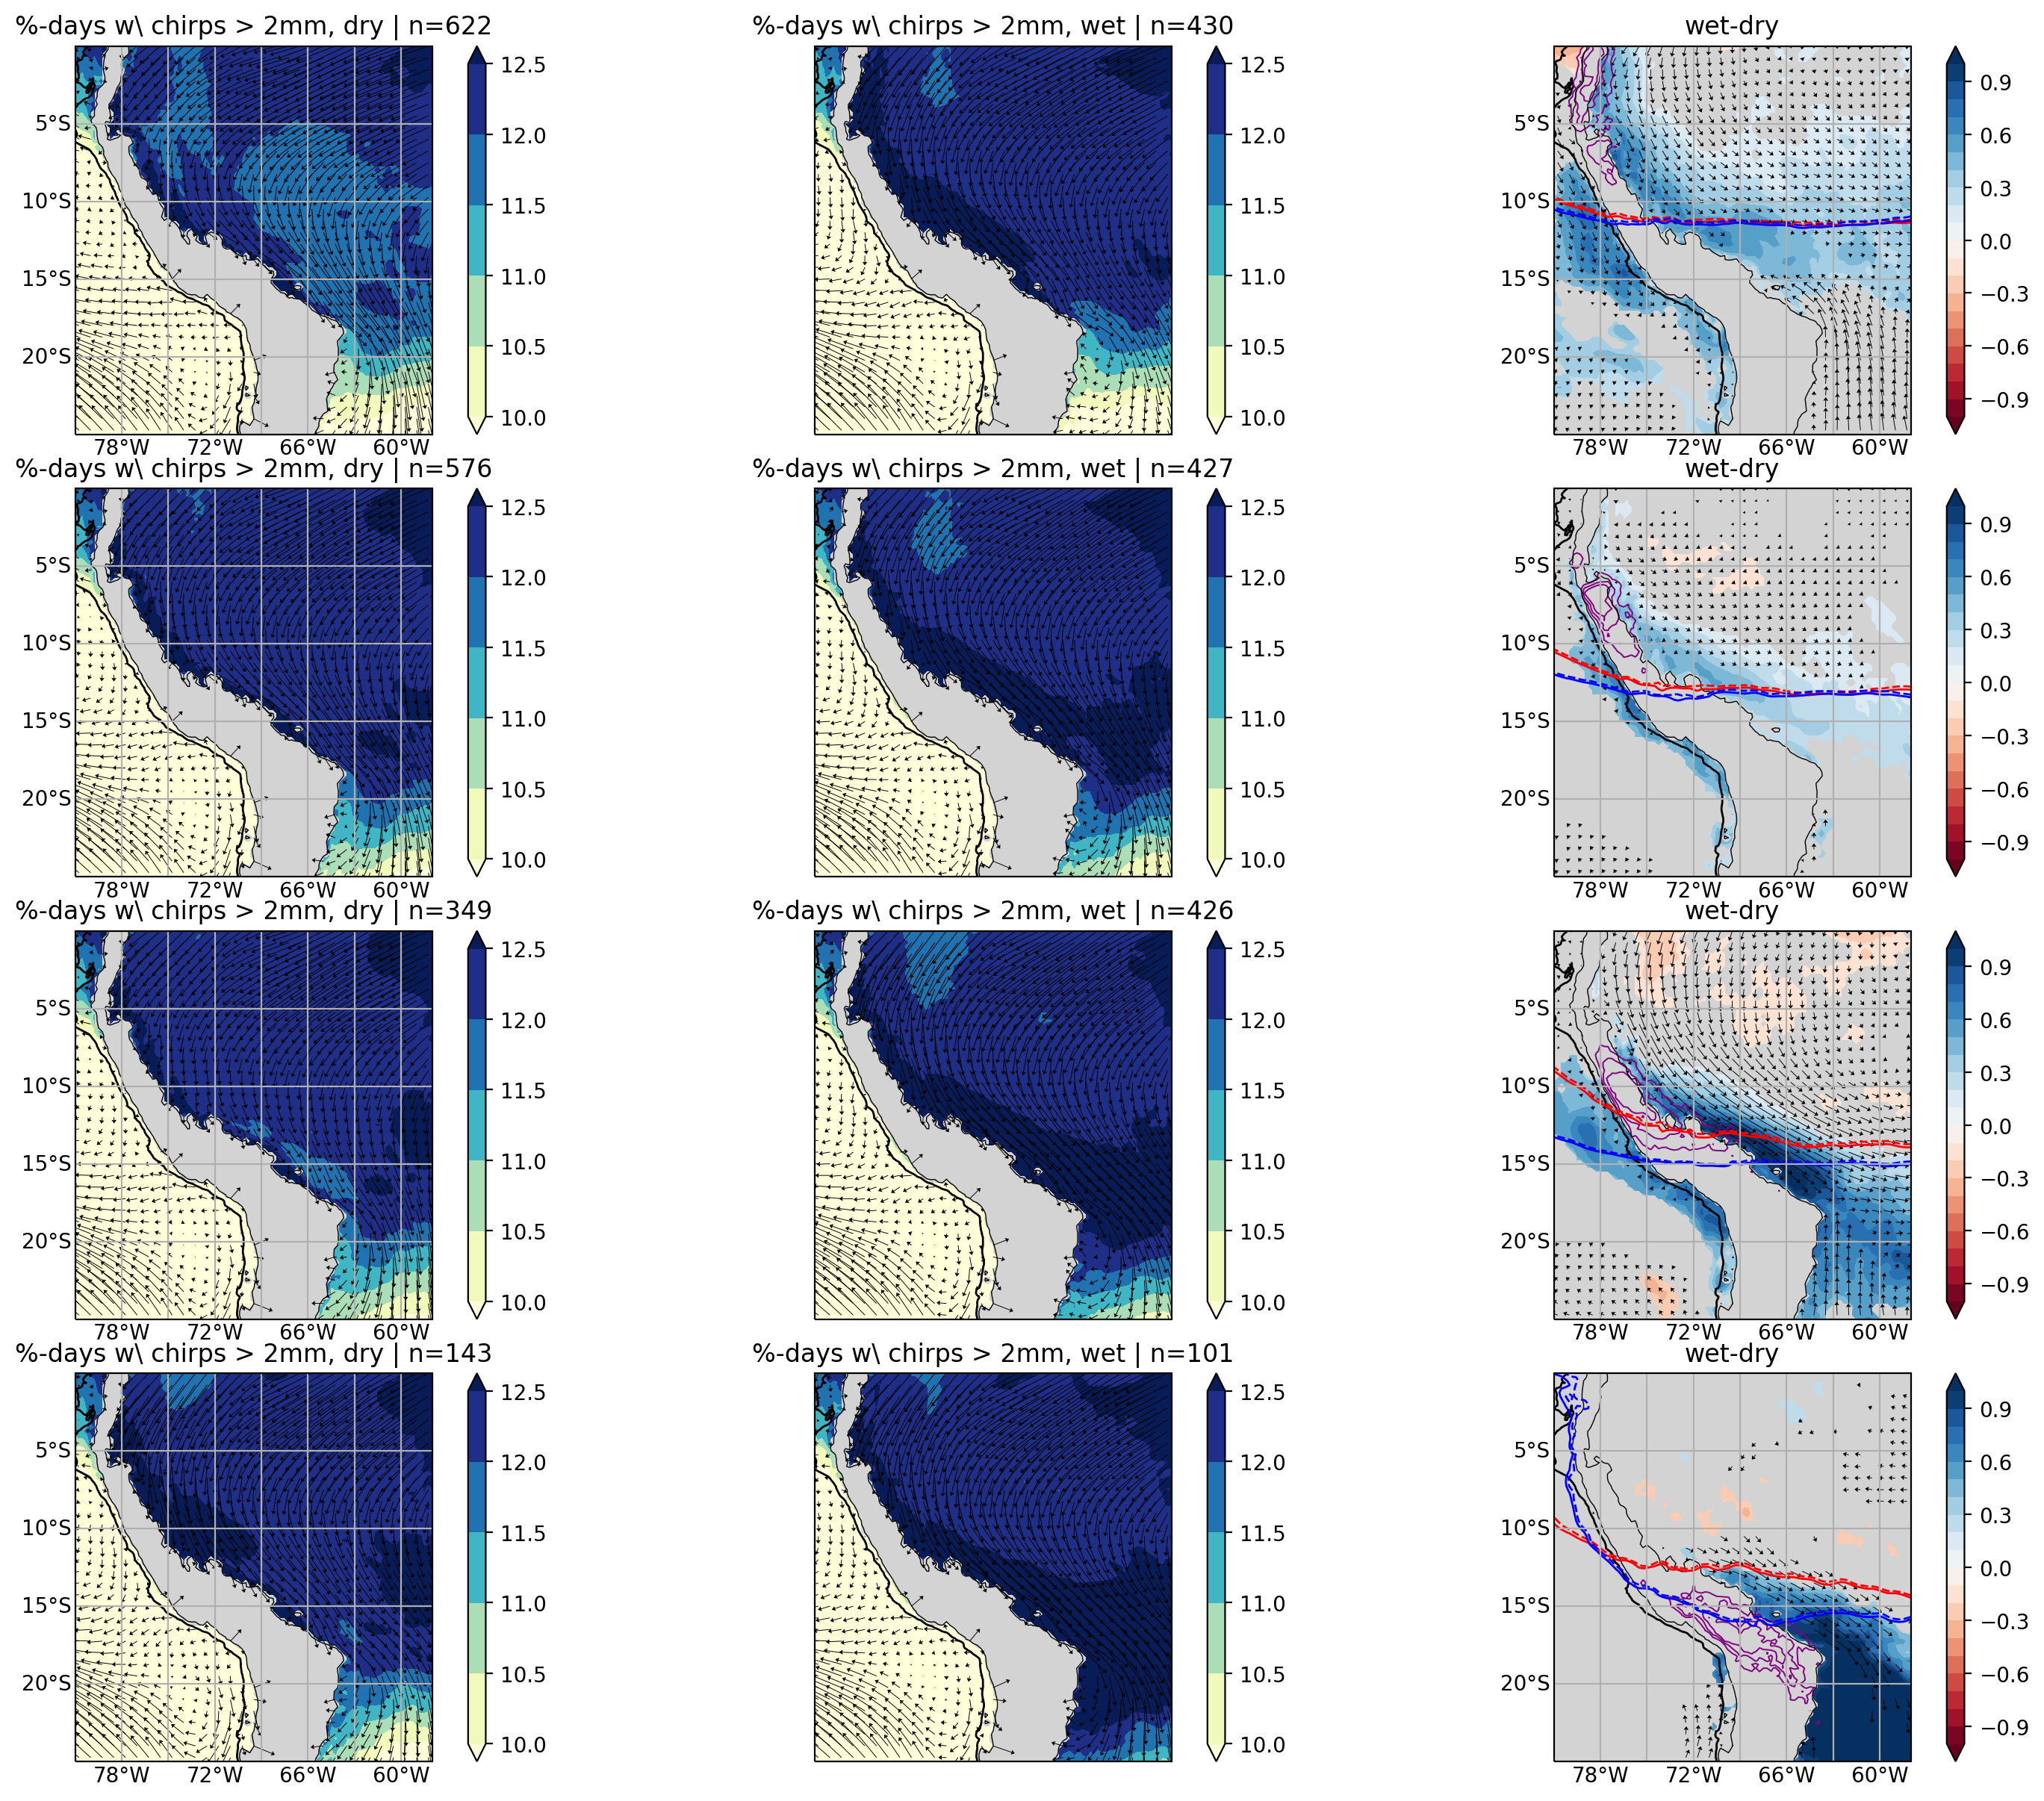

In [29]:
area = 0.15
f = plt.figure(figsize=(15,12), dpi=200)
plus = [1,2,3]
var='q'
cnt = 0

for ids, reg in enumerate(['equatorial', 'transition', 'central', 'southern']):
    
#     if reg == 'transition':
#         area=0.2
#     else:
    area=0.15
    
    dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+reg+"_dw_spellDates_"+str(area)+"perc_v2.p", "rb"))

    dd = dic['dry3']#+ pd.Timedelta('1days')
    wd = dic['wet3']#+ pd.Timedelta('1days')
    
    drytir = np.intersect1d(maps.time.values, dd)
    wettir = np.intersect1d(maps.time.values, wd)
    
    mapsdry = maps.sel(time=dd).mean('time').where(height<1500)
    mapswet = maps.sel(time=wd).mean('time').where(height<1500)
    
    mapsdryq = mapsq['q'].sel(time=dd).mean('time').where(height<1500)
    mapswetq = mapsq['q'].sel(time=wd).mean('time').where(height<1500)
    qtstat, qpval = stats.ttest_ind(mapsq['q'].sel(time=dd), mapsq['q'].sel(time=wd), axis=0, equal_var=False)
    qmask = qpval<=0.05
    
    mapsdryu = mapsu.sel(time=dd).mean('time').where(height<1500)
    mapswetu = mapsu.sel(time=wd).mean('time').where(height<1500)
    utstat, upval = stats.ttest_ind(mapsu.sel(time=dd)['u'], mapsu.sel(time=wd)['u'], axis=0, equal_var=False)
    umask = upval<=0.05
    
    wtstat, wpval = stats.ttest_ind(maps.sel(time=dd)['v'], maps.sel(time=wd)['v'], axis=0, equal_var=False)
    wmask = wpval<=0.05
    
    
    mapsdryu2 = mapsu2.sel(time=dd).mean('time') #-pd.Timedelta('1days')
    mapswetu2 = mapsu2.sel(time=wd).mean('time') #-pd.Timedelta('1days')
#     mapsdryv2 = mapsv2.sel(time=dd).mean('time') #-pd.Timedelta('1days')
#     mapswetv2 = mapsv2.sel(time=wd).mean('time') #-pd.Timedelta('1days')

    dryti = np.intersect1d(tir.time.values, dd)
    wetti = np.intersect1d(tir.time.values, wd)
    
    tirdry = tir.where(tir>1).sel(time=drytir).count('time')/len(drytir)*100
    tirwet = tir.where(tir>1).sel(time=wettir).count('time')/len(wettir)*100
    
    uanodry = mapsdryu['u']
    vanodry = mapsdry['v'] # multiplied by 10 since vertical component is very small compared to horizontal one
    uanowet = mapswetu['u']
    vanowet = mapswet['v']
    st=3
    sarrow = 1
    xquiv = mapsdryu.longitude[sarrow::st]
    yquiv = mapsdryu.latitude[sarrow::st]

    uud = (uanodry)[sarrow::st, sarrow::st]  
    vvd = (vanodry)[sarrow::st, sarrow::st]

    uuw = (uanowet)[sarrow::st, sarrow::st]  
    vvw = (vanowet)[sarrow::st, sarrow::st]
    
    bothmask = umask[sarrow::st, sarrow::st] | wmask[sarrow::st, sarrow::st] 
   # ipdb.set_trace()
 

    ax = f.add_subplot(4,3,(ids+1)+cnt, projection=ccrs.PlateCarree())
    ax.set_facecolor('lightgrey')

    ax.coastlines()
            # Gridlines
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False

    plt.contourf(mapsdry.longitude, mapsdry.latitude, mapsdryq*1000, levels=np.arange(10,13,0.5), cmap='YlGnBu', transform=ccrs.PlateCarree(), extend='both')
    plt.colorbar()
    plt.contour(height.longitude, height.latitude, height, levels=[-5,1500], colors='k', linewidths=0.5)
    plt.quiver(xquiv, yquiv, uud, vvd, scale=55, width=0.002, headwidth=7)
    ax.set_xlim(-81,-58)
    ax.set_ylim(-25,0)
    plt.title('%-days w\ chirps > 2mm, dry | n='+str(len(dd)))

    ax = f.add_subplot(4,3,ids+2+cnt, projection=ccrs.PlateCarree())
    ax.set_facecolor('lightgrey')
    ax.coastlines()
    plt.contourf(mapswet.longitude, mapsdry.latitude, mapswetq*1000, levels=np.arange(10,13,0.5), cmap='YlGnBu', transform=ccrs.PlateCarree(), extend='both')
    plt.colorbar()
    plt.contour(height.longitude, height.latitude, height, levels=[-5,1500], colors='k', linewidths=0.5)
    plt.quiver(xquiv, yquiv, uuw, vvw, scale=55, width=0.002, headwidth=7)
    xl.top_labels = False
    xl.right_labels = False
    ax.set_xlim(-81,-58)
    ax.set_ylim(-25,0)
    plt.title('%-days w\ chirps > 2mm, wet | n='+str(len(wd)))

    ax = f.add_subplot(4,3,ids+3+cnt, projection=ccrs.PlateCarree())
    ax.set_facecolor('lightgrey')
    ax.coastlines()
    plt.contourf(mapswet.longitude, mapsdry.latitude, (mapswetq-mapsdryq).where(qmask)*1000, levels=np.arange(-1,1.1,0.1),cmap='RdBu', transform=ccrs.PlateCarree(), extend='both')
    plt.colorbar()
    plt.contour(tirwet.longitude, tirwet.latitude, (tirwet-tirdry), levels=[30,40,50], colors=['purple'] , transform=ccrs.PlateCarree(), extend='both', linewidths=0.7)
    
    plt.contour(height.longitude, height.latitude, height, levels=[-5,1500], colors='k', linewidths=0.5)
    plt.contour(mapswet.longitude, mapsdry.latitude,mapsdryu2['u'], levels=[-0.1,0.1], colors='r', linewidths=1)
    plt.contour(mapswet.longitude, mapsdry.latitude,mapswetu2['u'], levels=[-0.1,0.1], colors='b', linewidths=1)
    plt.quiver(xquiv, yquiv, (uuw-uud).where(bothmask), (vvw-vvd).where(bothmask), scale=55, width=0.002, headwidth=7)
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    ax.set_xlim(-81,-58)
    ax.set_ylim(-25,0)
    plt.title('wet-dry')
    
    cnt +=2

    plt.tight_layout()
    #f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/correlations/drywet/gridsat_3days_day0_'+pregion+'.jpg')

In [120]:
toreg = ['equatorial', 'transition', 'central', 'southern']
def map_2d(ax, reg):
    
    if reg == 'transition':
        area=0.2
    else:
        area=0.15
    
    dic = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+reg+"_dw_spellDates_"+str(area)+"perc_v2.p", "rb"))

    dd = dic['dry3']#+ pd.Timedelta('1days')
    wd = dic['wet3']#+ pd.Timedelta('1days')
    
    drytir = np.intersect1d(maps.time.values, dd)
    wettir = np.intersect1d(maps.time.values, wd)
    
    mapsdry = maps.sel(time=dd).mean('time').where(height<1500)
    mapswet = maps.sel(time=wd).mean('time').where(height<1500)
    
    mapsdryq = mapsq['q'].sel(time=dd).mean('time').where(height<1500)
    mapswetq = mapsq['q'].sel(time=wd).mean('time').where(height<1500)
    qtstat, qpval = stats.ttest_ind(mapsq['q'].sel(time=dd), mapsq['q'].sel(time=wd), axis=0, equal_var=False)
    qmask = qpval<=0.05
    
    mapsdryu = mapsu.sel(time=dd).mean('time').where(height<1500)
    mapswetu = mapsu.sel(time=wd).mean('time').where(height<1500)
    utstat, upval = stats.ttest_ind(mapsu.sel(time=dd)['u'], mapsu.sel(time=wd)['u'], axis=0, equal_var=False)
    umask = upval<=0.05
    
    wtstat, wpval = stats.ttest_ind(maps.sel(time=dd)['v'], maps.sel(time=wd)['v'], axis=0, equal_var=False)
    wmask = wpval<=0.05
    
    
    mapsdryu2 = mapsu2.sel(time=dd).mean('time') #-pd.Timedelta('1days')
    mapswetu2 = mapsu2.sel(time=wd).mean('time') #-pd.Timedelta('1days')
#     mapsdryv2 = mapsv2.sel(time=dd).mean('time') #-pd.Timedelta('1days')
#     mapswetv2 = mapsv2.sel(time=wd).mean('time') #-pd.Timedelta('1days')

    dryti = np.intersect1d(tir.time.values, dd)
    wetti = np.intersect1d(tir.time.values, wd)
    
    tirdry = tir.where(tir>1).sel(time=drytir).count('time')/len(drytir)*100
    tirwet = tir.where(tir>1).sel(time=wettir).count('time')/len(wettir)*100
    
    uanodry = mapsdryu['u']
    vanodry = mapsdry['v'] # multiplied by 10 since vertical component is very small compared to horizontal one
    uanowet = mapswetu['u']
    vanowet = mapswet['v']
    st=3
    sarrow = 1
    xquiv = mapsdryu.longitude[sarrow::st]
    yquiv = mapsdryu.latitude[sarrow::st]

    uud = (uanodry)[sarrow::st, sarrow::st]  
    vvd = (vanodry)[sarrow::st, sarrow::st]

    uuw = (uanowet)[sarrow::st, sarrow::st]  
    vvw = (vanowet)[sarrow::st, sarrow::st]
    
    bothmask = umask[sarrow::st, sarrow::st] | wmask[sarrow::st, sarrow::st] 
#    # ipdb.set_trace()
 

#     ax = f.add_subplot(4,3,(ids+1)+cnt, projection=ccrs.PlateCarree())
#     ax.set_facecolor('lightgrey')

#     ax.coastlines()
#             # Gridlines
#     xl = ax.gridlines(draw_labels=True);
#     xl.top_labels = False
#     xl.right_labels = False

#     plt.contourf(mapsdry.longitude, mapsdry.latitude, mapsdryq*1000, levels=np.arange(10,13,0.5), cmap='YlGnBu', transform=ccrs.PlateCarree(), extend='both')
#     plt.colorbar()
#     plt.contour(height.longitude, height.latitude, height, levels=[-5,1500], colors='k', linewidths=0.5)
#     plt.quiver(xquiv, yquiv, uud, vvd, scale=55, width=0.002, headwidth=7)
#     ax.set_xlim(-81,-58)
#     ax.set_ylim(-25,0)
#     plt.title('%-days w\ chirps > 2mm, dry | n='+str(len(dd)))

#     ax = f.add_subplot(4,3,ids+2+cnt, projection=ccrs.PlateCarree())
#     ax.set_facecolor('lightgrey')
#     ax.coastlines()
#     plt.contourf(mapswet.longitude, mapsdry.latitude, mapswetq*1000, levels=np.arange(10,13,0.5), cmap='YlGnBu', transform=ccrs.PlateCarree(), extend='both')
#     plt.colorbar()
#     plt.contour(height.longitude, height.latitude, height, levels=[-5,1500], colors='k', linewidths=0.5)
#     plt.quiver(xquiv, yquiv, uuw, vvw, scale=55, width=0.002, headwidth=7)
#     xl.top_labels = False
#     xl.right_labels = False
#     ax.set_xlim(-81,-58)
#     ax.set_ylim(-25,0)
#     plt.title('%-days w\ chirps > 2mm, wet | n='+str(len(wd)))

    ax.set_facecolor('lightgrey')
    ax.coastlines()
    plt.contourf(mapswet.longitude, mapsdry.latitude, (mapswetq-mapsdryq).where(qmask)*1000, levels=np.arange(-1,1.1,0.1),cmap='RdBu', transform=ccrs.PlateCarree(), extend='both', alpha=0.8)
    plt.colorbar()
    plt.contour(tirwet.longitude, tirwet.latitude, (tirwet-tirdry), levels=[30,50], colors=['purple'] , transform=ccrs.PlateCarree(), extend='both', linewidths=1.2)
    
    plt.contour(height.longitude, height.latitude, height, levels=[-5,1500], colors='k', linewidths=0.5)
    plt.contour(mapswet.longitude, mapsdry.latitude,mapsdryu2['u'], levels=[-5,0.01], colors='r', linewidths=1)
    plt.contour(mapswet.longitude, mapsdry.latitude,mapswetu2['u'], levels=[-5,0.01], colors='b', linewidths=1)
    plt.quiver(xquiv, yquiv, (uuw-uud).where(bothmask), (vvw-vvd).where(bothmask), scale=55, width=0.0015, headwidth=7)
    xl = ax.gridlines(draw_labels=True);
    xl.top_labels = False
    xl.right_labels = False
    xl.xlines = False
    xl.ylines = False
    ax.set_xlim(-81.5, -60)
    ax.set_ylim(-25,0)
    ax.set_title(reg)
    
    return ax

In [121]:
def draw_cross(ax, data, lon, lat, title=None, xlabel=None, ylabel=None,  cmap=None,mask_sig=None, quiver=None, contour=None, cbar_label=None, twinx=None, cbar=True,**kwargs):

    mapp = ax.contourf(lon, lat, data, extend='both', alpha=0.8, cmap=cmap, **kwargs)  # this is the actual plot
    
#     cmapp = uplot.discrete_cmap(25, base_cmap=cmap)
#     mapp = ax.pcolormesh(lon, lat,data,cmap=cmapp, vmin=50, vmax=68)
    ax.set_ylim(170,1000)
    
    #ax.set_xlim(-81.5,-60)
    # Adjust the y-axis to be logarithmic
    #ax.set_yscale('symlog')
    #ax.set_yticklabels(np.arange(1000, 50, -1000)
    
    #ax.set_yticks(np.arange(1000, 50, -100))
    plt.gca().invert_yaxis()
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    if quiver is not None:
        
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'], width=0.0015, headwidth=6, color='darkblue')
#         qk = plt.quiverkey(qu, 0.45, 0.52, 1, '1 m s$^{-1}$ | ',
#                            labelpos='E', coordinates='figure')
        
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], colors=contour['colours'], linewidths=0.5 )
        plt.clabel(cs, inline=1, fontsize=8, fmt='%1.1f')  #, fmt='%1.1f'
        
    if twinx is not None:
        ax1 = ax.twinx()
        ax1.plot(twinx['x'], twinx['y'], twinx['color'] )
        ax1.set_ylabel(twinx['ylabel'])
        ax1.set_ylim(twinx['ylim'][0], twinx['ylim'][1])
    
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if cbar:
        cbar = plt.colorbar(mapp, pad=0.09, format='%1.1f')  # adds colorbar '%d'
        #cbar = plt.colorbar(mapp, ticks=np.linspace(50,68,25), pad=0.09)
        cbar.set_label(cbar_label)
    
    #return mapp

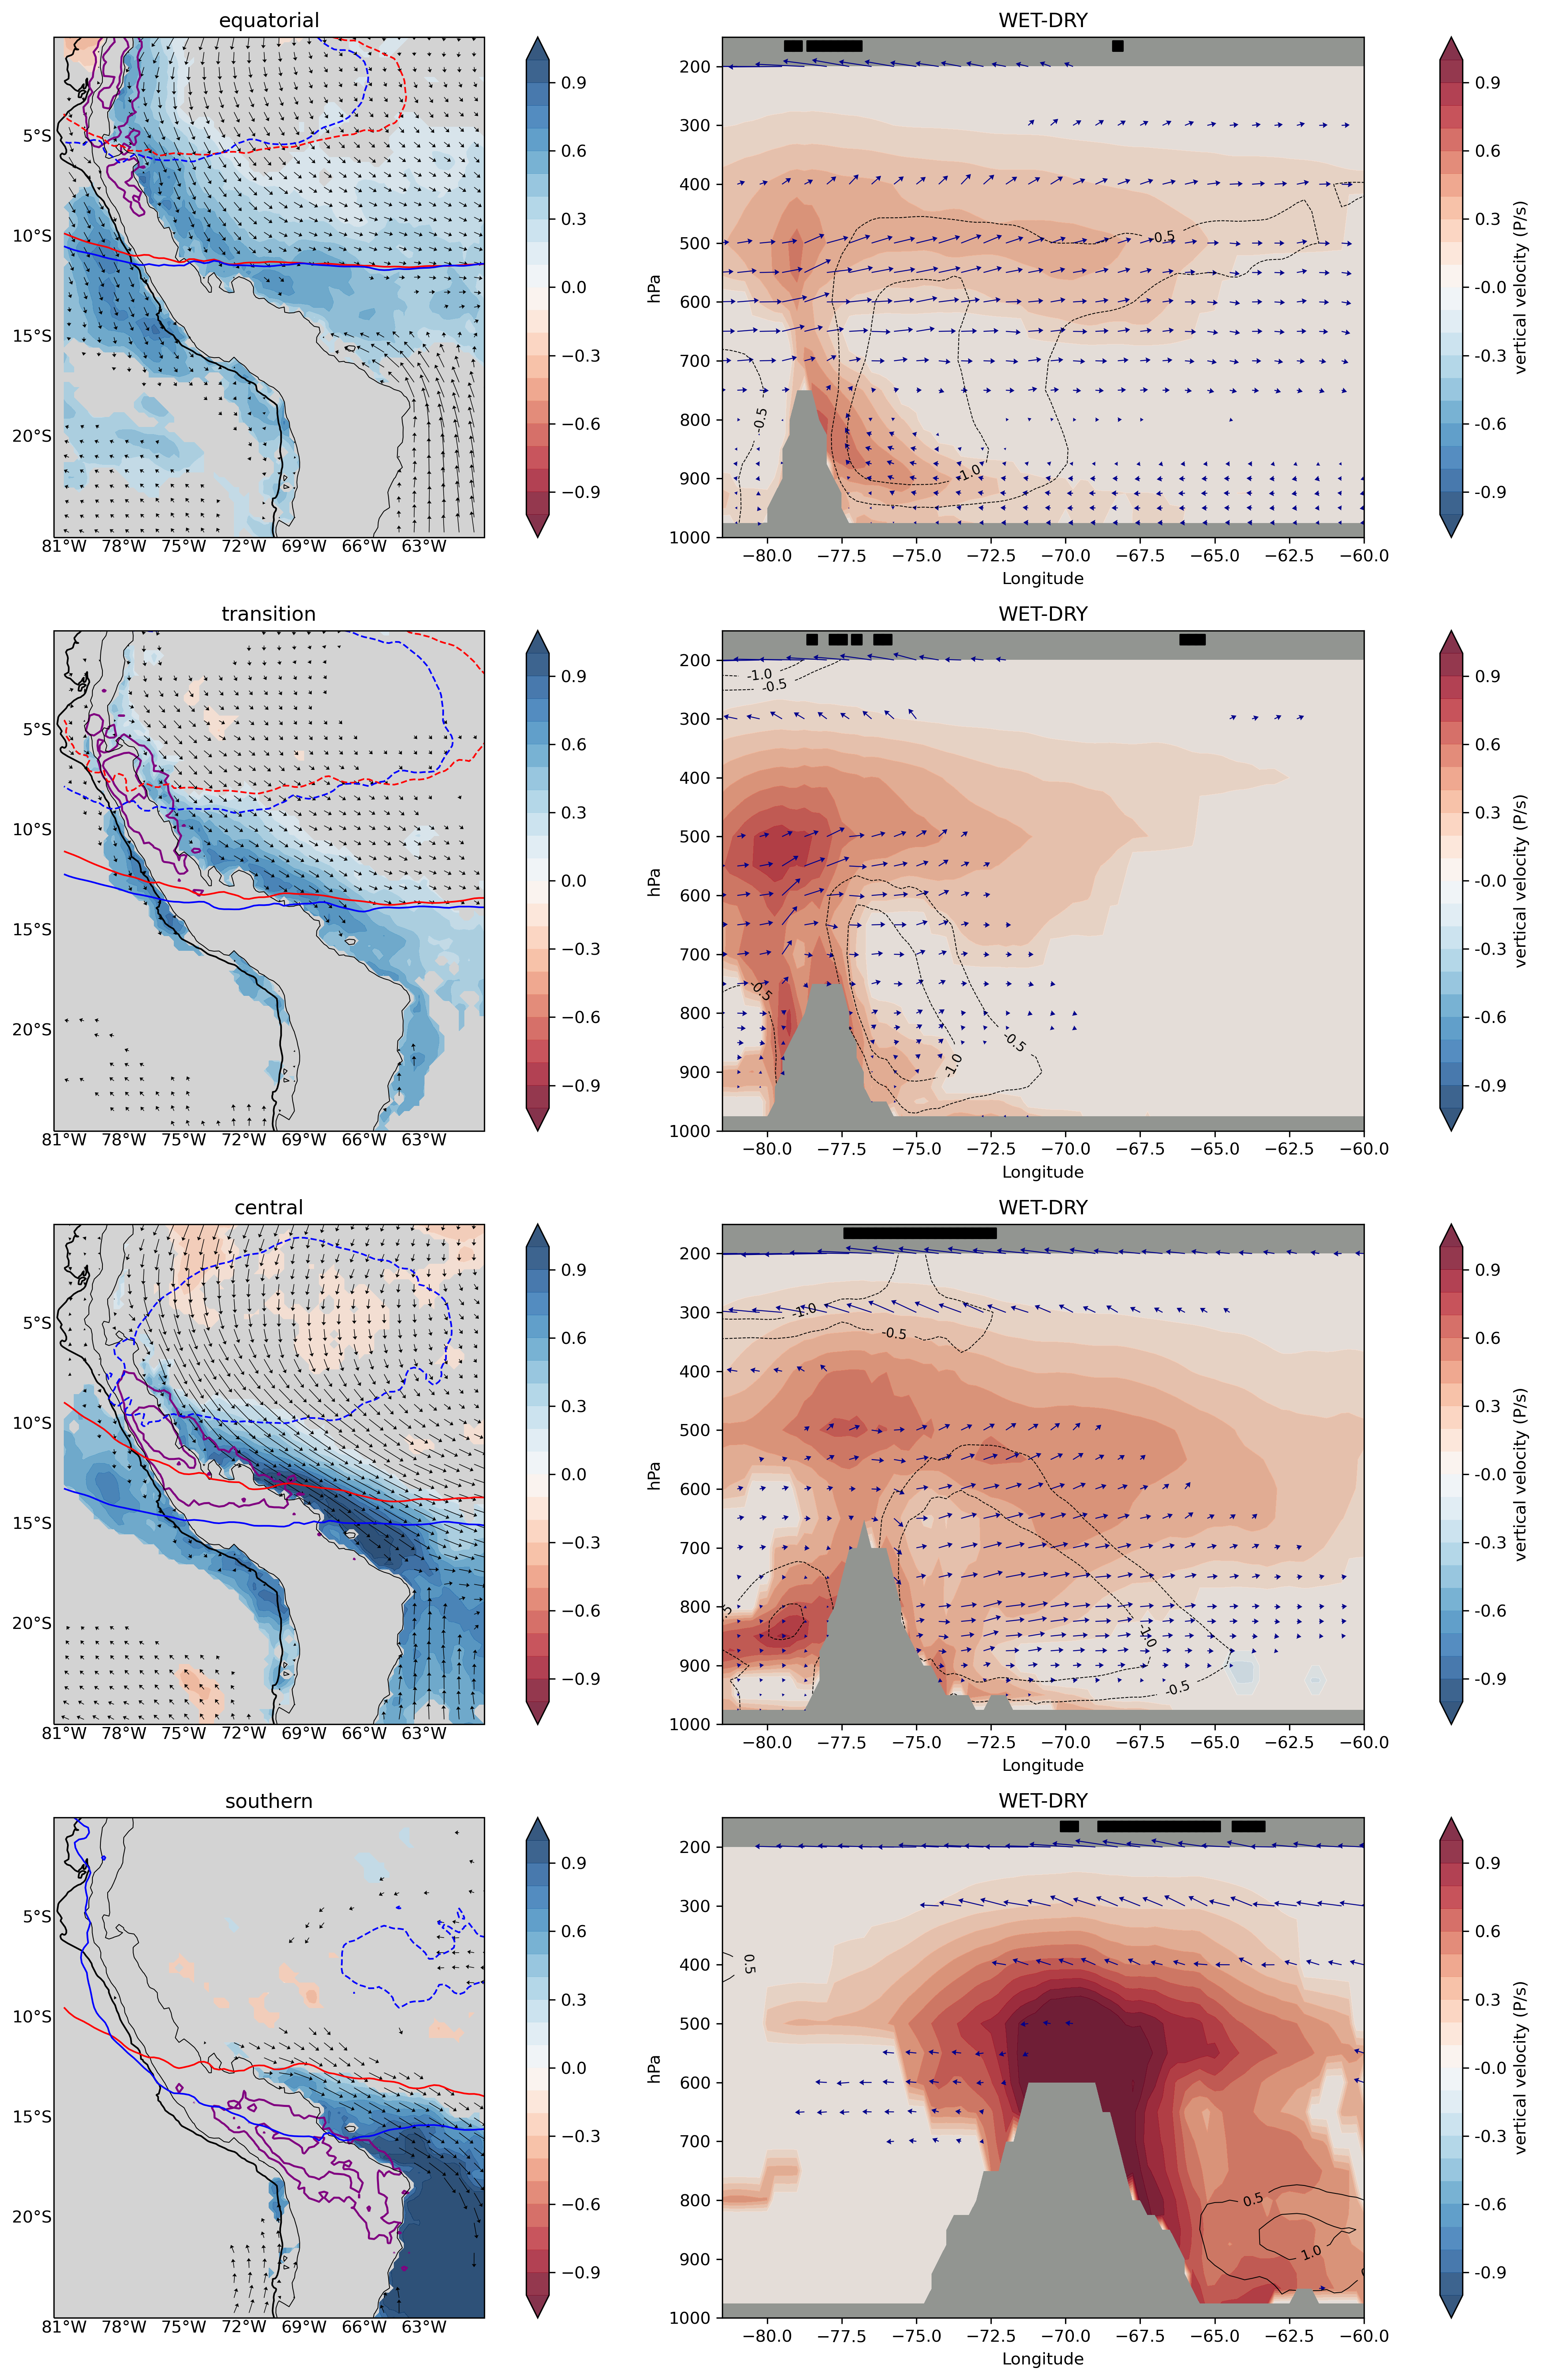

In [122]:
slices_months = [ ('3d equatorial DRY', equatorial_dic['wet'], equatorial_dic['wet_ttest'],equatorial_dic['dry'], equatorial_dic['dry_ttest']),
                  ('3d transition DRY', transition_dic['wet'], transition_dic['wet_ttest'],transition_dic['dry'], transition_dic['dry_ttest']),
                 ('3d central DRY', central_dic['wet'], central_dic['wet_ttest'],central_dic['dry'], central_dic['dry_ttest']),   #dry_clim_allc.mean('time')
                 ('3w southern DRY',southern_dic['wet'], southern_dic['wet_ttest'],southern_dic['dry'], southern_dic['dry_ttest']) ]  # mean_wet3, all_wet3, doy_wetclim3, wet_clim_all) ]

f = plt.figure(figsize=(15,20), dpi=300)
cnt = 0
cnt2=0
for ids in range(9):
    
    if ids in [0,2,4,6]:
        ax1 = f.add_subplot(4,2,ids+1, projection=ccrs.PlateCarree())
        
        ax1 = map_2d(ax1, toreg[cnt2])
        cnt2 = cnt2+1
            
    
    
    if ids in [1,3,5,7]:
        
        dd = slices_months[cnt]
        
        slices = dd[1] # d/w mean
        tag = dd[0]

        slices_ttest = dd[2] #  d/w all, for day-wise t-test, all days versus only wet/dry
        slice_clim = dd[3] # doy d/w clim
        clim_ttest = dd[4]

        # "current zonal wind" wind vectors
        #ipdb.set_trace()
        vano = slices['u']
        wano = slices['w']*(-15)  # multiplied by 10 since vertical component is very small compared to horizontal one
        vclim = slice_clim['u']
        wclim = slice_clim['w']*(-15)
        st=2
        stt = 3
        sarrow = 1
        xquiv = slices.longitude[sarrow::stt]
        yquiv = slices.level

        uu = (vano)[::, sarrow::stt]  
        ww = (wano)[::, sarrow::stt]
        uuc = (vclim)[::, sarrow::stt]  
        wwc = (wclim)[::, sarrow::stt] 
        utstat, upval = stats.ttest_ind(slices_ttest['u'], clim_ttest['u'], axis=0, equal_var=False)
        umask = upval<=0.05

        wtstat, wpval = stats.ttest_ind(slices_ttest['w'], clim_ttest['w'], axis=0, equal_var=False)
        wmask = wpval<=0.05
        
        vtstat, vpval = stats.ttest_ind(slices_ttest['v'], clim_ttest['v'], axis=0, equal_var=False)
        vmask = vpval<=0.05

        bothmask = umask[::, sarrow::stt] #| wmask[::, sarrow::stt] 
        #ipdb.set_trace()


        uu = uu-uuc
        ww = ww-wwc
        uu = uu.where(bothmask)
        ww = ww.where(bothmask)

        qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 70}

        # temperature and moisture check

        var3 = 'd'
        data3 = (slices[var3])*1500000 # #- slice_clim[var] - slice_clim[var]
        a3= slices_ttest[var3] 
        b3= clim_ttest[var3]
        tstat3, pval3= stats.ttest_ind(a3, b3, axis=0)
        mask3= pval3<=0.05

        data3.values[(~mask3)] = 0

        dpos = np.where((data3.values[0,:])>10)

        #ipdb.set_trace()

        var = 'q'
        var2 = 'q'
        data2 = (slices[var]- slice_clim[var])*1000 # 
        a = slices_ttest[var2] 
        b = clim_ttest[var2]
        tstat, pval = stats.ttest_ind(a, b, axis=0)
        mask = pval<=0.05

        data2.values[(~mask) & (np.isfinite(data2.values))] = 0

        data = slices['v']-slice_clim['v'] #+ ((slices['v']-slice_clim['v']))
        data4 = slices['u']-slice_clim['u']
        
        data5 = np.sqrt(data**2+data4**2)
#         wswet = np.sqrt(slices_ttest['u']**2+slices_ttest['v']**2)
#         wsdry = np.sqrt(clim_ttest['u']**2+clim_ttest['v']**2)
        
        #wsstat, wspval = stats.ttest_ind(wswet,wsdry, axis=0, equal_var=False)
        #wsmask = wspval<=0.05
        
        #data5.values[(~wsmask)] = 0

        
        ax = f.add_subplot(4,2,ids+1)
        
        conlev = [-1,-0.5]
        if cnt==3:
            data = data4
            conlev = [0.5,1]

        #conlev=[2, 50]

        contour = {'data' : data, 'x' :slices.longitude, 'y' : slices.level, 'levels' : conlev, 'colours' : 'k'}  #np.arange(335,355, 1)
        #contour = {'data' : data3, 'x' :slices.longitude, 'y' : slices.level, 'levels' : [8,10], 'colours' : 'k'}
        draw_cross(ax, data2, slices.longitude, slices.level, ylabel = 'hPa', xlabel='Longitude',cmap='RdBu_r', quiver=qin, contour=contour, cbar_label='vertical velocity (P/s)', levels=np.arange(-1,1.1,0.1), title='WET-DRY') #np.arange(-2, 2.1, 0.25)  #Spectral
        #ax.contour(slices.longitude, slices.level, data4, levels=[1,2,5], colors='purple', linewidths=1)
        #ipdb.set_trace()
        ax.scatter(slices.longitude[dpos[0]], [165]*len(dpos[0]), color='k', marker='s')
        ax.set_facecolor('xkcd:grey')
        ax.set_ylim(1000, 150)
        ax.set_xlim(-81.5, -60)
        cnt = cnt+1
plt.tight_layout()
f.savefig('/home/ck/DIR/cornkle/figs/HUARAZ/paper/drywet_cross_map.jpg')